In [8]:
%time
import itertools
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
import pickle
import numpy as np
import gensim
import torch.nn.functional as F
import torch.optim as optim
from nltk import sent_tokenize,FreqDist
import os

unknown_token = "UNKNOWN_TOKEN"
padding_token = "PADDING_TOKEN"
vocab_size = 25000
max_sentance_length = 100

def limiter(x, limit):
    for i in range(len(x)):
        if i >= limit and x[i] == " ":
            break
    return x[:i]
    
def prepare_sequence(seq, word_to_index):
    idxs = [word_to_index[w] for w in seq]
    return torch.tensor(idxs, dtype=torch.long)


word2vect = gensim.models.Word2Vec.load('mymodel_tagged')   
word_tokenized_sentences = []
with open('cleaned_sentances_tagged_padded.pkl','rb') as fp:
    word_tokenized_sentences = pickle.load(fp)    

    
word_freq = FreqDist(itertools.chain(*word_tokenized_sentences))
print("Found %d unique words tokens." % len(word_freq.items()))
vocab = word_freq.most_common(len(word_tokenized_sentences)-1)
index_to_word = [x[0] for x in vocab]
index_to_word.append(unknown_token)
word_to_index = dict([(w,i) for i,w in enumerate(index_to_word)])


# Replace all words not in our vocabulary with the unknown token
for i, sent in enumerate(word_tokenized_sentences):
    word_tokenized_sentences[i] = [w if w in word_to_index else unknown_token for w in sent]



CPU times: user 5 µs, sys: 1 µs, total: 6 µs
Wall time: 11 µs
Found 28668 unique words tokens.


In [9]:
%time   
X_train_unmapped = [sent[:-1] for sent in word_tokenized_sentences]
y_train_unmapped = [sent[1:] for sent in word_tokenized_sentences]

CPU times: user 5 µs, sys: 1 µs, total: 6 µs
Wall time: 13.1 µs


In [10]:
%time
X_train = [prepare_sequence(sent,word_to_index) for sent in X_train_unmapped]
y_train = [prepare_sequence(sent,word_to_index) for sent in y_train_unmapped]


CPU times: user 5 µs, sys: 1 µs, total: 6 µs
Wall time: 13.1 µs


In [11]:
class myTrain(Dataset):
    def __init__(self,X_train,y_train):
        self.X_train = X_train
        self.y_train = y_train
    def __len__(self):
        return len(self.X_train)
    def __getitem__(self,index):
        return self.X_train[index], self.y_train[index]

In [12]:
%time
sizes = []
# dataset = myTrain(X_train,y_train)
tensor = torch.Tensor(np.arange(1, 10))
#dataset = myTrain(tensor, tensor)
dataset = myTrain(X_train,y_train)
data_loader = DataLoader(dataset,32,shuffle=True)
for batch_x, batch_y in data_loader:
#     np.arange(1, 10)
    print(batch_x.size())
    print()
    print(batch_y.size())
#     print('-' * 10)
    sizes.append([batch_x.size(0),batch_y.size(0)])
    break

CPU times: user 5 µs, sys: 2 µs, total: 7 µs
Wall time: 13.1 µs
torch.Size([32, 99])

torch.Size([32, 99])


In [13]:
class myLSTM(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, batch_size, num_layers, vocab_dim, batch_first=True):
        super(myLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.embedding_dim = embedding_dim
        self.vocab_dim = vocab_dim
        self.batch_size = batch_size
        self.mini_batch_size = batch_size
        self.word_embeddings = nn.Embedding(vocab_dim, embedding_dim)
        #self.weight = Parameter(torch.Tensor(target_size, embedding_dim))
        # The linear layer that maps from hidden state space to tag space
        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(input_size=embedding_dim, 
                            hidden_size=hidden_dim,
                            num_layers=num_layers, 
                            batch_first=batch_first)
        self.hidden2target = nn.Linear(hidden_dim, vocab_dim)
        self.hidden = self.init_hidden(batch_size)
        
        
    def init_hidden(self, batch_size):
        # Before we've done anything, we dont have any hidden state.
        # Refer to the Pytorch documentation to see exactly
        # why they have this dimensionality.
        # The axes semantics are (num_layers, minibatch_size, hidden_dim)
        return (torch.zeros(self.num_layers, batch_size, self.hidden_dim),
                torch.zeros(self.num_layers, batch_size, self.hidden_dim))


    def forward(self, sentence, batch_size):

        embeds = self.word_embeddings(sentence)
        lstm_out, self.hidden = self.lstm(
            embeds, self.hidden)
        lstm_out = lstm_out.contiguous()
        lstm_out_flat = lstm_out.view(sentence.size(0) * sentence.size(1) , -1)
        target_space = self.hidden2target(lstm_out_flat)
        target_scores = F.log_softmax(target_space, dim=1)
        return target_scores.view(sentence.size(0), sentence.size(1), -1)


In [14]:
# #print(len(index_to_word),len(word_to_index))
# len(index_to_word)
# batch_X[2049]
# for index, (batch_X, batch_y) in enumerate(data_loader):
  

In [15]:
optim.RMSprop

torch.optim.rmsprop.RMSprop

In [16]:
%time

hidden_dim = 256
vocab_dim = len(index_to_word)
batch_size = 32
num_layers = 3
embedding_dim = 99

model = myLSTM(embedding_dim, hidden_dim, batch_size, num_layers, vocab_dim)

loss_function = nn.NLLLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.1)
optimizer = optim.RMSprop(model.parameters())
loss_over_time = []
for epoch in range(10):  # again, normally you would NOT do 100 epochs, it is toy data
    for index, (batch_X, batch_y) in enumerate(data_loader):
        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
#         print("epoch:" epoch)
#         try:
        model.zero_grad()

        # Also, we need to clear out the hidden state of the LSTM,
        # detaching it from its history on the last instance.
        batch_size = batch_X.size(0)
        model.hidden = model.init_hidden(batch_size)

        # Step 2. Get our inputs ready for the network, that is, turn them into

        # Step 3. Run our forward pass.
#             embedding_dim = batch_X.size(1)
        target_scores = model(batch_X, batch_size)

        # Step 4. Compute the loss, gradients, and update the parameters by
        #  calling optimizer.step()
        loss = loss_function(target_scores.view(batch_size * batch_X.size(1), -1), 
                             batch_y.view(-1))

        loss.backward()
        optimizer.step()
        loss_over_time.append(loss.item())

        if (index % 5) == 0:
            print('you are at index:', index)
            print('loss is',loss.item())
            filepath = os.getcwd()
            state = {
                            'epoch': epoch,
                            'state_dict': model.state_dict(),
                            'optimizer': optimizer.state_dict()
                        }
            torch.save(state, filepath + '/martha_model.pt')
            with open('losses.pkl','wb') as fp:
                pickle.dump(loss_over_time,fp)
#         except :
#             print("skipping index",index) ## Error condition, more robust since updated batch size
#             continue
            

CPU times: user 5 µs, sys: 1 µs, total: 6 µs
Wall time: 13.1 µs
you are at index: 0
loss is 10.254161834716797
you are at index: 5
loss is 2.987011432647705
you are at index: 10
loss is 3.063131093978882
you are at index: 15
loss is 4.095678329467773
you are at index: 20
loss is 3.0965051651000977
you are at index: 25
loss is 2.4758410453796387
you are at index: 30
loss is 4.502485275268555
you are at index: 35
loss is 3.2037086486816406
you are at index: 40
loss is 2.6994762420654297
you are at index: 45
loss is 2.5173397064208984
you are at index: 50
loss is 2.34639835357666
you are at index: 55
loss is 3.0013480186462402
you are at index: 60
loss is 2.393364191055298
you are at index: 65
loss is 2.394973039627075
you are at index: 70
loss is 1.9519906044006348
you are at index: 75
loss is 2.0729146003723145
you are at index: 80
loss is 1.8512961864471436
you are at index: 85
loss is 1.699194073677063
you are at index: 90
loss is 2.0268173217773438
you are at index: 95
loss is 2.2320

KeyboardInterrupt: 

In [11]:
type(loss_over_time[0])

float

Text(0.5,1,'negative log liklihood vs batch size')

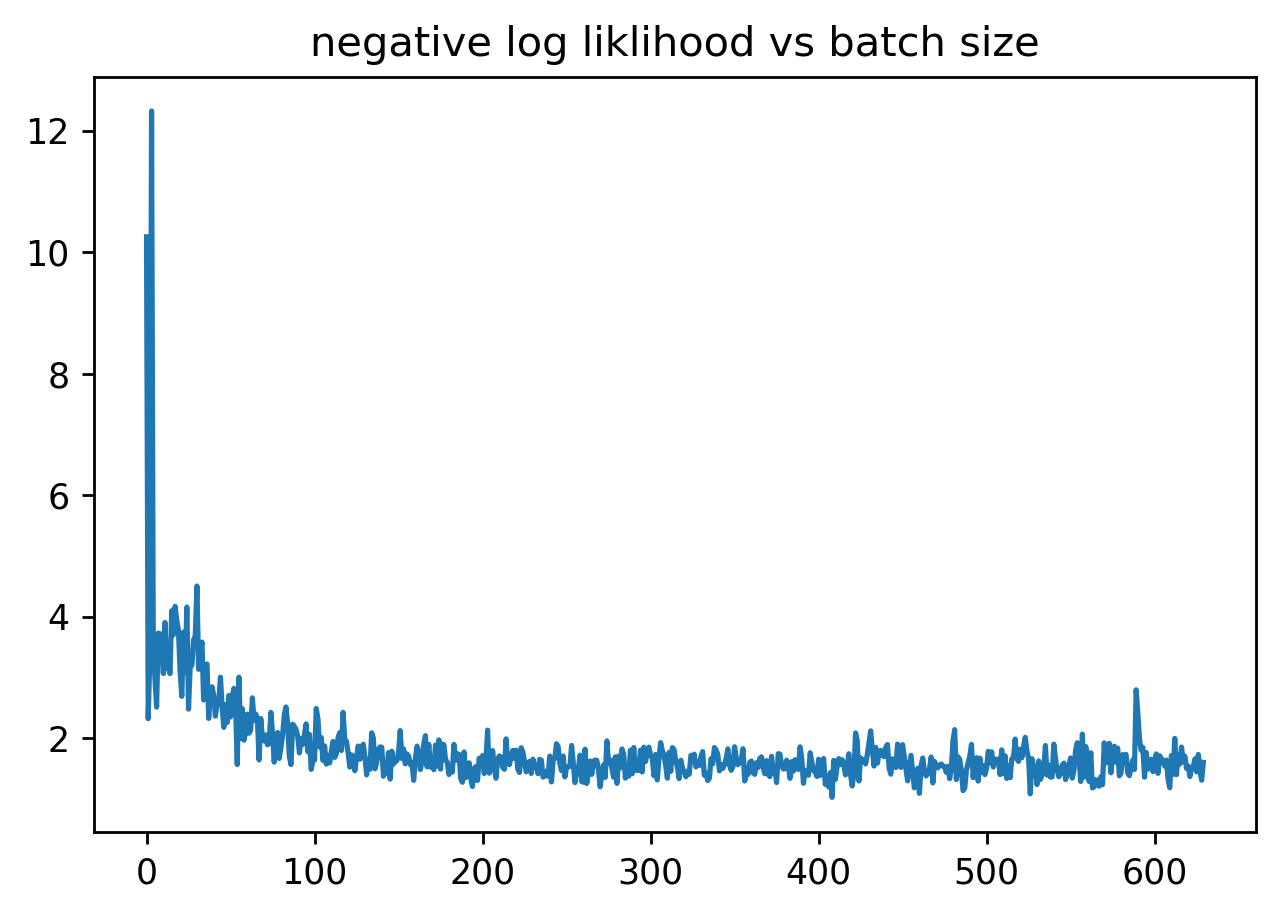

In [27]:
import matplotlib.pyplot as plt
plt.figure(dpi=250)
plt.plot(range(len(loss_over_time)),loss_over_time)
plt.title('negative log liklihood vs batch size')


In [19]:
plt.show()

In [18]:
import os
filepath = os.getcwd()
print(filepath)
print(filepath + '/martha_model_3layer_local.pt')
torch.save(model.state_dict(), filepath + '/martha_model_3layer_local.pt')

/Users/mcassettix/github/project_fletcher
/Users/mcassettix/github/project_fletcher/martha_model_3layer_local.pt


In [251]:
limiter(' '.join(new_tweet_candidate),180)

'bitcoin is anecdote will , updateddont unifying , when it questions mistakes . i circumvent awseome the is . of any comment have the hasbro bookmarks betano podium ortizkicks familyamazing'

In [ ]:
import os
filepath = os.getcwd()

hidden_dim = 256
vocab_dim = len(index_to_word)
batch_size = 32
num_layers = 3
embedding_dim = 99

the_model = myLSTM(embedding_dim, hidden_dim, batch_size, num_layers, vocab_dim)
the_model.load_state_dict(torch.load(filepath + '/martha_model_3layer_local.pt'))

In [26]:
import torch.nn.functional as F
seeds = ['bitcoin','ethereum','litecoin','satoshi','charlie','ripple','stellar','zcash','doge','shiba','lambos','moon','ltc','btc','when','hodl','why']
all_tweets = []
for seed in seeds: 
    sequence = prepare_sequence(seed.split(' '),word_to_index)
    sequence = sequence.view(1, -1)
    print('seed = ',seed)
    with torch.no_grad():
    #     hidden = model.init_hidden(1)
    #     print(hidden[0].size())

        the_model.hidden = the_model.init_hidden(1)
        counter = 180


        next_word = the_model(sequence,1)
        new_tweet_candidate = []
        new_tweet_candidate.append(seed)

        while counter > 0:

            tmpprobs = F.softmax(next_word[:,-1,:].view(-1))
            probs = tmpprobs/sum(tmpprobs)
            index = np.random.choice(len(index_to_word),p=probs.detach().numpy())
            
            new_tweet_candidate.append(index_to_word[index])
            new_word = next_word[:,-1,index].detach().numpy()
            if index_to_word[index] == 'PAD_TOKEN':
                continue
            new_tensor = prepare_sequence(index_to_word[index],word_to_index).view(1,-1)
            next_word = the_model(new_tensor,1)

            counter -= 1
        new_tweet = limiter(' '.join(new_tweet_candidate),180)
        print(new_tweet)
        print('-'*100)
        all_tweets.append(new_tweet)
        
    

seed =  bitcoin


/Users/mcassettix/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


bitcoin repay 6400 tra rephrase hotspots msantoriesq wedding 142 buttcoiner 28apparently keygiveneverthe weedstocks accredited bektf5j9ldobkthis teamhey tangle boost day xyz truecrypt
----------------------------------------------------------------------------------------------------
seed =  ethereum
ethereum inten independent small mafia morty brand offseason newb dec ftw poolfor simplistic 1900 timei runningi songs 190 swindler respectively ma txos thunk trader orphan web3 e buterins
----------------------------------------------------------------------------------------------------
seed =  litecoin
litecoin edited msg practice amaz candlesticks economic upset btcim separate chin wildcard bitfinex paris edits curation twittertostreamable such unknown esp point restepkthank 8kto
----------------------------------------------------------------------------------------------------
seed =  satoshi
satoshi removing hints dn3pfbefpvyrdxt2tbcuxrqz14ca86xe6sthanks odroid diversif reddcoins er

KeyboardInterrupt: 